,Batch,x1,x2,y
0,0.0,-8.630697,-5.509461,-15.177179
1,0.0,2.429707,4.461679,-3.034724
2,0.0,9.223992,-0.138533,-40.431662
3,0.0,-0.581540,9.872013,-10.784934
4,0.0,-4.725866,-2.768824,-6.485489
5,1.0,-0.357006,-0.520635,-1.098090
6,1.0,-1.256182,1.913543,-2.929692
7,1.0,0.163143,2.274057,-0.651705
8,1.0,-0.047039,4.056535,-1.790036
9,1.0,-2.726401,3.088285,-8.816176


,x1,x2,y
0,-8.630697,-5.509461,-15.177179
1,2.429707,4.461679,-3.034724
2,9.223992,-0.138533,-40.431662
3,-0.581540,9.872013,-10.784934
4,-4.725866,-2.768824,-6.485489
5,-0.357006,-0.520635,-1.098090
6,-1.256182,1.913543,-2.929692
7,0.163143,2.274057,-0.651705
8,-0.047039,4.056535,-1.790036
9,-2.726401,3.088285,-8.816176


,x1,x2
0.3,0.982642,0.017358


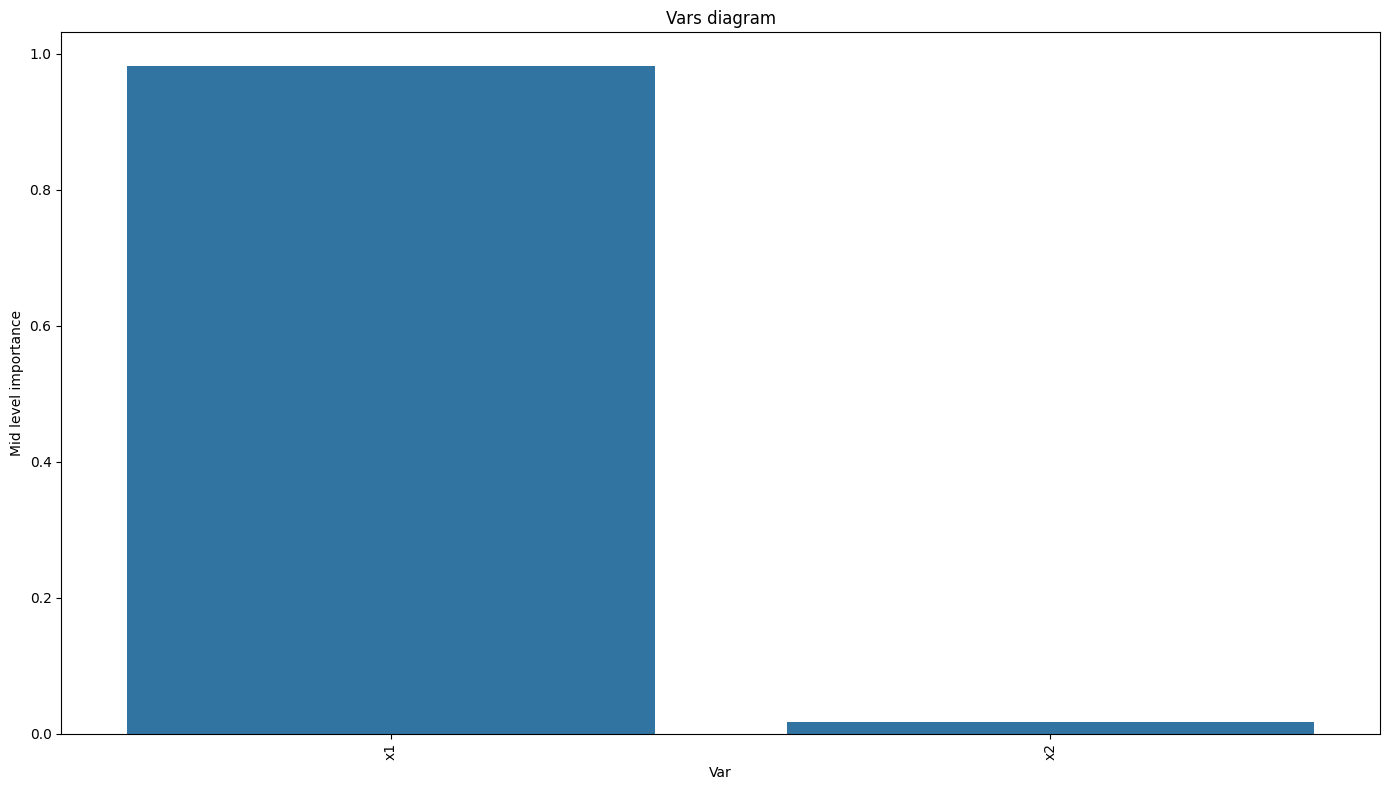

In [97]:
from bayesian_optimization import BayesianOptimization
import pandas as pd 
from botorch.test_functions import Ackley
from botorch.test_functions import Levy 
from botorch.test_functions import Rosenbrock
from varstool import DVARS
import seaborn as sns
import matplotlib.pyplot as plt

# Variables that determine the size of the dataset
N_INITIAL = 5
EPOCHS = 5
BATCH_SIZE = 5
DIM = 2
LOWER = -10
UPPER = 10

optimizer = BayesianOptimization(fun=Levy(dim=DIM,negate=True), 
                                 batch_size=BATCH_SIZE, 
                                 dim=DIM, 
                                 epochs=EPOCHS, 
                                 n_init=N_INITIAL, 
                                 lower_bound=LOWER,
                                 upper_bound=UPPER,
                                 seed=3,
                                 acqf_type='qUCB')

x_max, y_max = optimizer.run()
data = optimizer.get_data()
full = optimizer.format(data, dim=DIM, n_init=N_INITIAL, batch_size=BATCH_SIZE, epochs=EPOCHS)
display(full)

vars_data = full.drop(columns=['Batch'])

display(vars_data)
vars_data.to_csv('vars_data.csv', index=False)
h = 0.3
experiment = DVARS(data_file = 'vars_data.csv',
                   outvarname = 'y',
                   ivars_range = h,
                   phi0=1,
                   phi_max=1e6,
                   tol = 1e-6,
                   correlation_func_type='linear',
                   report_verbose=False)

experiment.run()
display(experiment.ratios)
 
data = pd.DataFrame(experiment.ratios, index=[h])
data = data.T.sort_values(by=h, ascending=False).T

plt.figure(figsize=(14, 8))
sns.barplot(x=data.columns, y=data.iloc[0])
plt.xticks(rotation=90)
plt.title('Vars diagram')
plt.xlabel('Var')
plt.ylabel('Mid level importance')
plt.tight_layout()

plt.show()

,x1,x2
0.3,0.884238,0.115762


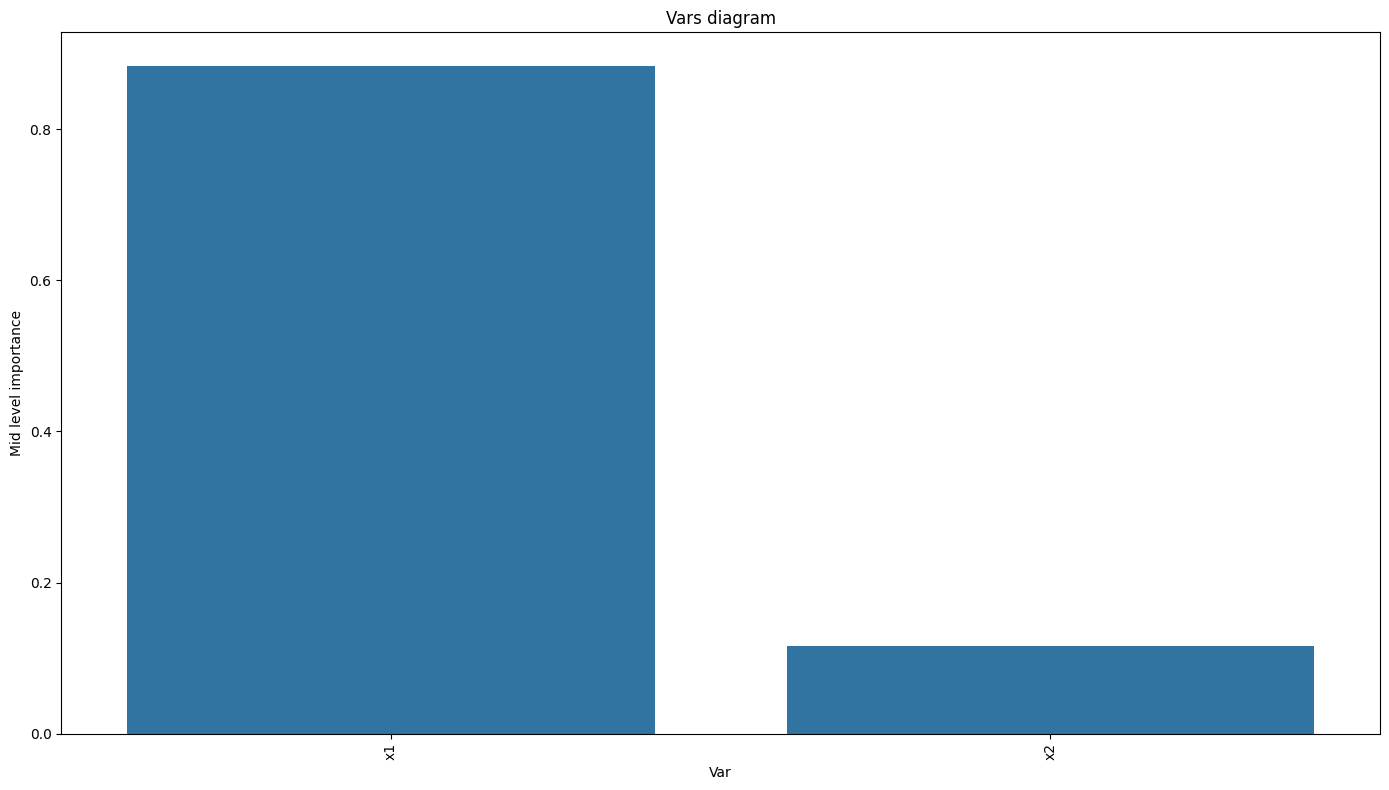

In [100]:
from botorch.test_functions import Levy
import torch
DIM = 2
LOWER = -10
UPPER = 10
N = 25
fun=Levy(dim=DIM,negate=True)

fun.bounds[0, :].fill_(LOWER) # Bounds of the function
fun.bounds[1, :].fill_(UPPER)

samples = (UPPER - LOWER) * torch.rand(N, DIM) + LOWER
y_values = torch.tensor([fun(sample) for sample in samples])

data = {
    'x1': samples[:, 0].numpy(),
    'x2': samples[:, 1].numpy(),
    'y': y_values.numpy()
}
vars_df = pd.DataFrame(data)

vars_df.to_csv('vars_data_true.csv', index=False)
h = 0.3
experiment = DVARS(data_file = 'vars_data_true.csv',
                   outvarname = 'y',
                   ivars_range = h,
                   phi0=1,
                   phi_max=1e6,
                   tol = 1e-6,
                   correlation_func_type='linear',
                   report_verbose=False)

experiment.run()
display(experiment.ratios)
 
data = pd.DataFrame(experiment.ratios, index=[h])
data = data.T.sort_values(by=h, ascending=False).T

plt.figure(figsize=(14, 8))
sns.barplot(x=data.columns, y=data.iloc[0])
plt.xticks(rotation=90)
plt.title('Vars diagram')
plt.xlabel('Var')
plt.ylabel('Mid level importance')
plt.tight_layout()

plt.show()

In [96]:
import numpy as np
import pandas as pd
from varstool import VARS, Model

my_parameters = { 'x1': [ -5, 10 ], 
                  'x2': [ -5, 10 ], }

def rosenbrock(x):
    '''Rosenbrock test function for d=2'''
    # check whether the input x is a dataframe or list or numpy array
    if not isinstance(x, (pd.core.frame.DataFrame, pd.core.series.Series, np.ndarray, list)):
        raise TypeError('`x` must be of type pandas.DataFrame, numpy.ndarray, pd.Series, or list')

    if len(x) != 2:
        raise ValueError('`x` must have exactly two elements')

    x1 = x[0]
    x2 = x[1]
    
    return 100 * (x2 - x1**2)**2 + (1 - x1)**2


rosenbrock_model = Model(rosenbrock)

# Initialize the VARS object
experiment_1 = VARS(parameters     = my_parameters,
                    num_stars      = 100,
                    delta_h        = 0.1,
                    ivars_scales   = (0.1, 0.3, 0.5),
                    sampler        = 'lhs',
                    seed           = 123456789,
                    model          = rosenbrock_model,
                    bootstrap_flag = True,
                    bootstrap_size = 100,
                    bootstrap_ci   = 0.9,
                    grouping_flag  = True,
                    num_grps       = 2,
                    report_verbose = True,
                    )

# Run the analysis
results = vars.run_online()

model evaluation:   0%|          | 0/122425 [00:00<?, ?it/s]/var/folders/tn/_5w3fjw13jn7qf4h0l1cqc040000gn/T/ipykernel_17307/1436557563.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1 = x[0]
/var/folders/tn/_5w3fjw13jn7qf4h0l1cqc040000gn/T/ipykernel_17307/1436557563.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2 = x[1]
building pairs:   2%|▏         | 3/200 [03:53<4:15:54, 77.94s/it]


KeyboardInterrupt: 

In [76]:
print(results)

None


In [46]:
print(experiment_1.ivars)

           x1        x2        x3
0.1  0.066097  0.229198  0.059902
0.3  0.961455  2.147283  0.574615
0.5  3.313248  3.035793  1.461225
